<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW4_woodenML_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 4 (pro): древесные алгоритмы**

### **Постановка задач**

### **Домашнее задание состоит из двух подзадач:**

**1. В  разделе 1 ваша задача:**
-  реализовать свое решающее дерево
- сравнить его со стандартной имплементацией из sklearn

Функции и классы дерева вы должны оформить в модуль `hw4_code_pro.py`.

**2. В разделе два ваша задача:** решить задачу бинарной классификации при помощи написанного Вами дерева, а также леса из sklearn, а после интерпретировать лучшие модели. Чуть точнее

- Извлечь данные из базы данных;
- Предобработать датасет;
- Обучить собственный класс DT, а также RF из `sklearn` в как базовом варианте (гиперпараметры по умолчанию), так и с подбором гиперпараметров;
- Интерпретировать алгоритмы при помощи LIME или SHAP.


### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**
- Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.
- Неэффективная реализация кода может негативно отразиться на оценке.

### **Формат сдачи:**
Задания сдаются через  anytask. Посылка должна содержать:
* Ноутбук в формате ipynb
* Модуль hw4_code_pro.py


### **Баллы:**

Суммарно за задание можно получить 10 основных баллов и 1 бонусный балло.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 2 февраля 23:59

**Продуктивной и интересной вам работы!**


In [1]:
!pip install optuna
!pip install lime
!pip install shap
!pip install psycopg2-binary

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import psycopg2
import psycopg2.extras

import shap
import lime
import lime.lime_tabular

import optuna

import pickle
from typing import Tuple

import warnings
warnings.filterwarnings('ignore')

# **1. Решающие деревья своими руками (6 баллов)**

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

Всего за часть вы можете получить 6 основных баллов и 1 бонусный.

### **Задание 1. (1 балл)**

Реализуйте функцию find_best_split из модуля hw4_code_pro.py

In [3]:
def find_best_split(feature_vector, target_vector):
    """
    Под критерием Джини здесь подразумевается следующая функция:
    $$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r)$$,
    $R$ — множество объектов, $R_l$ и $R_r$ — объекты, попавшие в левое и правое поддерево,
     $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ — доля объектов класса 1 и 0 соответственно.

    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    
    
    th0, _ = np.unique(feature_vector, return_counts=True)
    th1 = np.append(0, th0)[:-1]
    thresholds = ((th0+th1)*1./2)[1:]
    tmp_mass = np.append(feature_vector, th0)
    tmp_target = np.append(target_vector, np.ones(len(th0)))
    _, var_cumsum = np.unique(tmp_mass[np.where(tmp_target == 1)], return_counts=True)
    a_unique, value_count = np.unique(feature_vector, return_counts=True)

    def H(p_1):
        return (1-p_1**2-(1-p_1)**2)

    H_l_1 = (np.cumsum(var_cumsum-1)*1./np.cumsum(value_count))[:-1]
    H_r_1 = (np.cumsum(var_cumsum[::-1]-1) * 1. / np.cumsum(value_count[::-1]))[:-1][::-1]
    left_delitel = (np.cumsum(value_count) * 1. / len(target_vector))[:-1]
    ginis = -left_delitel * H(H_l_1) - (1-left_delitel) * H(H_r_1)
    if len(np.unique(feature_vector)) == 1:
        return [-1]*len(feature_vector), [-1]*len(feature_vector), -1, -1
    else:
        return thresholds, ginis, thresholds[np.argmax(ginis)], np.max(ginis)

### **Задание 2. (0.25 балла)**

Загрузите таблицу [students.csv](https://github.com/AnastasiyaMax/MLDS_ml_course_fall21/blob/main/hw/hw5_trees/students.csv). Это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling).

В наборе данных:
- признаки объекта записаны в первых пяти столбцах;
- в последнем записана целевая переменная (класс: 0 или 1).

По этим данным, используя функцию из задания 1, постройте:
- пять кривых "порог — значение критерия Джини" для всех пяти признаков;
- scatter-графики "значение признака — класс" для всех пяти признаков;

In [4]:
students = pd.read_csv("students.csv")

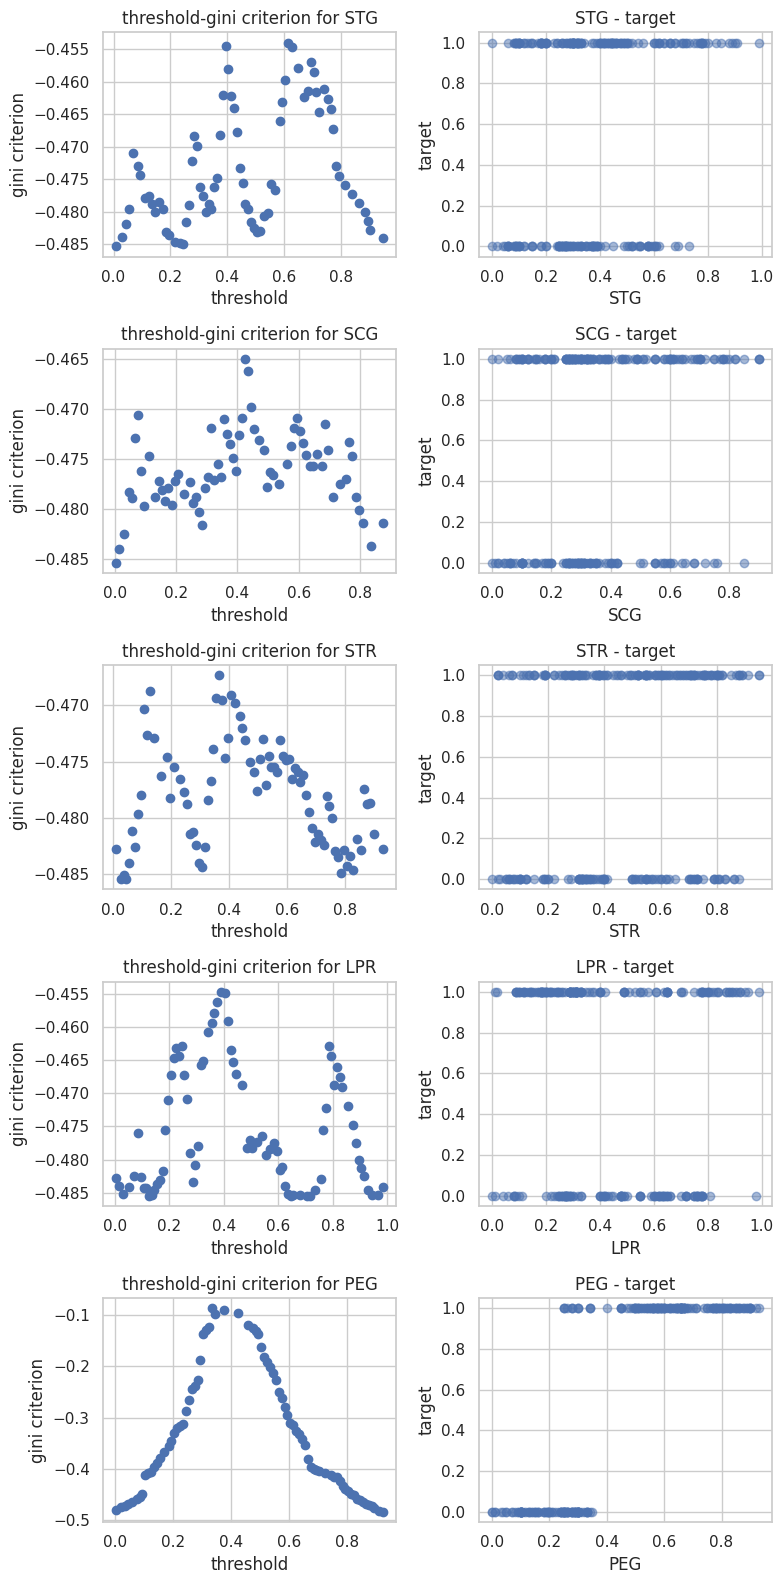

In [5]:
features = students.iloc[:, :-1]
target = students.iloc[:, -1].values


fig, axs = plt.subplots(5, 2, figsize=(8, 16))

for i, feature_name in enumerate(features.columns):
    feature_vector = features[feature_name].values
    thresholds, ginis, threshold_best, gini_best = find_best_split(feature_vector, target)

    if thresholds is not None and ginis is not None:
        axs[i, 0].scatter(thresholds, ginis)
        axs[i, 0].set_title(f'threshold-gini criterion for {feature_name}')
        axs[i, 0].set_xlabel('threshold')
        axs[i, 0].set_ylabel('gini criterion')
    
    # Scatter-график "значение признака — класс"
    axs[i, 1].scatter(feature_vector, target, alpha=0.5)
    axs[i, 1].set_title(f'{feature_name} - target')
    axs[i, 1].set_xlabel(f'{feature_name}')
    axs[i, 1].set_ylabel('target')

plt.tight_layout()
plt.show()


### **Задание 3. (0.6 балла)**

Проанализируйтте построенные кривые. Ответьте на поставленные вопросы:
- По какому признаку нужно производить деление выборки на два поддерева? (0.15 балла)
- Согласуется ли этот результат с визуальной оценкой scatter-графиков? (0.15 балла)
- Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? (0.15 балла)
- Чем отличаются кривые для признаков, по которым деление практически невозможно? (0.15 балла)

**Ответ:**
1) По признаку PEG,  выборка делиться почти идеально.  
2) Да, согласуется. На последнем графике наблюдается хорошо различимая граница разбиения.  
3) Хорошо виден максимум  
4) нет выраженного максимуму, кривая выглядит ровной, с небольшой дисперсией.

### **Задание 4. (1.15 балла)**

В некоторых случаях необходимо анализировать код исполненного класса на предмет оптимальности и ошибок. Потренируйтесь в этом!

- Разберитесь с уже написанным кодом в классе DecisionTree модуля hw4_code_pro.py.
- Найдите ошибки в реализации метода \_fit_node.
- Напишите функцию \_predict_node.

**Примечание 1:**

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева».
- Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

**Примечание 2:**

- Выбор лучшего разбиения необходимо производить по критерию Джини.
- Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку, чтобы Джини упал
- Ответ в листе: наиболее часто встречающийся класс в листе.


### **Задание 5. (0.5 балла)**

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Для этого:

- Скачайте таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/))
- Прочитайте данные с помощью pandas
- Примените к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа.
- Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные)
- Сделайте предсказания для оставшейся половины.
- Вычислите accuracy (так как мы используем эту метрику и в силу задачи, нам не очень важно, что будет классом 1, а что — классом 0).  


У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [6]:
mushrooms = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data")

In [7]:
from sklearn.preprocessing import LabelEncoder


encoder_map = {}

for col_name in mushrooms.columns:
    encoder = LabelEncoder()
    mushrooms.loc[:, col_name] =  encoder.fit_transform(mushrooms.loc[:, col_name])
    encoder_map.update({col_name : encoder})

y = mushrooms.iloc[:, 0]
X = mushrooms.iloc[:, 1:]
x_train, x_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.5, random_state=42)

In [8]:
from hw4_code_pro import DecisionTree

feature_types = ['categorical'] * len(X.columns)
custom_tree = DecisionTree(feature_types)

In [9]:
custom_tree.fit(x_train, y_train)

In [10]:
y_pred = custom_tree.predict(x_test)
print('test accuracy =', np.sum(y_pred == y_test) / np.size(y_test))
y_pred = custom_tree.predict(x_train)
print('train accuracy =', np.sum(y_pred == y_train) / np.size(y_train))
print('depth =', custom_tree.depth)

test accuracy = 1.0
train accuracy = 1.0
depth = 10


### **Задание 6. (бонус, 1 балл)**

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующее задание).

### **Задание 7. (2 балла)**

**1. Загрузите следующие наборы данных** (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (они записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

**2. Закодируйте категориальные признаки, использовав LabelEncoder.** С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

**Рекомендации:**
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами.

In [11]:
from hw4_code_pro import DecisionTree
from sklearn.preprocessing import LabelEncoder

In [12]:
mushrooms = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data")
mushrooms = mushrooms.drop('p', axis=1).join(mushrooms[['p']])
tic_tac_toe_endgame = pd.read_csv("https://archive.ics.uci.edu/static/public/101/data.csv")
car_evaluation = pd.read_csv("https://archive.ics.uci.edu/static/public/19/data.csv")
nursery  = pd.read_csv("https://archive.ics.uci.edu/static/public/76/data.csv")


In [13]:
val_sets = {
    'mushrooms': mushrooms,
    'tic_tac_toe_endgame': tic_tac_toe_endgame,
    'car_evaluation': car_evaluation,
    'nursery': nursery
}

In [14]:
from sklearn.model_selection import cross_val_score


results = {}

for set_name, df in val_sets.items():
    for col in df.columns:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    X_onehot = pd.get_dummies(X, prefix_sep="_", drop_first=True)
    
    models = {
        "DT_real": DecisionTree(feature_types=["real"] * X.shape[1]),
        "DT_cat": DecisionTree(feature_types=["categorical"] * X.shape[1]),
        "DT_onehot": DecisionTree(feature_types=["real"] * X_onehot.shape[1]),
        "sklearn_DT": DecisionTreeClassifier()
    }
    
    scores = {}
    for model_name, model in models.items():
        if model_name == "DT_onehot":
            scores[model_name] = np.mean(cross_val_score(model, X_onehot.values, y.values, cv=10, scoring="accuracy"))
        else:
            scores[model_name] = np.mean(cross_val_score(model, X.values, y.values, cv=10, scoring="accuracy"))

    results[set_name] = scores
    

In [15]:
results_df = pd.DataFrame(results)
results_df

mushrooms  tic_tac_toe_endgame  car_evaluation   nursery
DT_real      0.999261             0.475877        0.707595  0.785880
DT_cat       1.000000             0.541458        0.682162  0.854552
DT_onehot    0.999261             0.475877        0.707595  0.785880
sklearn_DT   0.958290             0.747719        0.864111  0.814738

### **Задание 8. (0.5 балла)**

Проанализируйте результаты эксперимента. Ответьте на вопросы:
- Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.
- Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
- Если случайность есть, то можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**  
1) Результаты разные. Разный подход к решению задач, различная работа алгоритмы, например в sklern другие гиперпараметры.
2) Да, разбиение при обучении разное.
3) Закреплять сиды, прдварительно зафиксировать разбиение на train и test. Подбирать гиперпараметры.

# **2. Задача бинарной классификации реализованным деревом (4 балла)**

Всего за эту часть можно получить 4 балла.

В этом разделе вам необходимо решить задачу бинарной классификации самописным деревом и лесом из sklearn, а после интерпретировать лучшие модели. А именно:

- Извлечь данные из базы данных;
- Предобработать датасет;
- Обучить собственный класс DT и RF из `sklearn` в как базовом варианте (гиперпараметры по умолчанию), так и с подбором гиперпараметров;
- Интерпретировать алгоритмы при помощи LIME или SHAP.


### **Познакомимся с задачей: постановка**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

In [16]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-02-12 16:10:19--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/home/jovyan/.postgresql/root.crt’

/home/jovyan/.postg 100%[===================>]   3.50K  --.-KB/s    in 0s      

2025-02-12 16:10:20 (4.67 GB/s) - ‘/home/jovyan/.postgresql/root.crt’ saved [3579/3579]



### **Задание 9. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

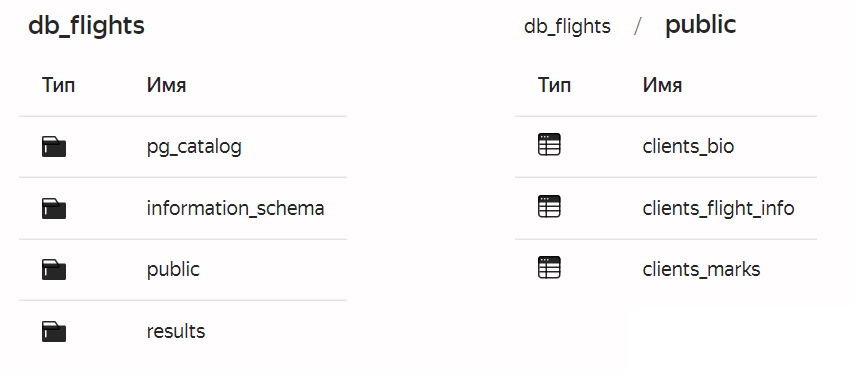

In [17]:
conn_params = {
    'host': 'rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net',
    'port': 6432,
    'sslmode': 'verify-full',
    'dbname': 'db_flights',
    'user': 'mlhs_student',
    'password': 'mlhs_student',
    'target_session_attrs': 'read-write'
}

In [18]:
with psycopg2.connect(**conn_params) as conn:
    with conn.cursor() as cursor:
        query = """
        SELECT 
            t1.id,
            t1.age,
            t1.gender,
            t2."Arrival Delay in Minutes",
            t2."Flight Distance",
            t2.class,
            t2."Type of Travel",
            t2."Customer Type",
            t2."Departure Delay in Minutes",
            t3."Inflight wifi service",
            t3.satisfaction,
            t3.cleanliness,
            t3."Inflight service",
            t3."Checkin service",
            t3."Baggage handling",
            t3."Seat comfort",
            t3."Online boarding",
            t3."Leg room service",
            t3."On-board service",
            t3."Inflight entertainment",
            t3."Food and drink",
            t3."Ease of Online booking",
            t3."Gate location",
            t3."Departure/Arrival time convenient"
                        
        FROM 
            db_flights.public.clients_bio t1
        JOIN 
            db_flights.public.clients_flight_info t2 ON t1.id = t2.id
        JOIN 
            db_flights.public.clients_marks t3 ON t1.id = t3.id;
        """

        cursor.execute(query)
        results = cursor.fetchall()
        column_names = [desc[0] for desc in cursor.description]

In [19]:
df = pd.DataFrame(results, columns=column_names).set_index('id')

In [20]:
assert df.shape == (129_549, 23)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [21]:
df_train = df[df.satisfaction != '-']

df_train.head()

age  gender Arrival Delay in Minutes Flight Distance     class  \
id                                                                    
7   43.0    Male                      0.0          1963.0  Business   
13  24.0    Male                     30.0           453.0       Eco   
18  61.0  Female                      0.0           821.0       Eco   
31  35.0    Male                      0.0           212.0  Business   
39  46.0  Female                      0.0            67.0  Business   

     Type of Travel      Customer Type Departure Delay in Minutes  \
id                                                                  
7   Business travel     Loyal Customer                        0.0   
13  Business travel  disloyal Customer                       16.0   
18  Personal Travel     Loyal Customer                        0.0   
31  Business travel  disloyal Customer                        0.0   
39  Business travel     Loyal Customer                        0.0   

   Inflight wifi service             satisfaction  ... Baggage handling  \
id                                                 ...                    
7                    3.0                satisfied  ...              5.0   
13                   2.0  neutral or dissatisfied  ...              4.0   
18                   2.0  neutral or dissatisfied  ...              5.0   
31                   2.0  neutral or dissatisfied  ...              5.0   
39                   3.0                satisfied  ...              4.0   

   Seat comfort Online boarding Leg room service On-board service  \
id                                                                  
7           5.0             4.0              5.0              5.0   
13          5.0             2.0              4.0              2.0   
18          5.0             1.0              2.0              5.0   
31          2.0             2.0              5.0              4.0   
39          4.0             5.0              4.0              4.0   

   Inflight entertainment Food and drink Ease of Online booking Gate location  \
id                                                                              
7                     5.0            5.0                    3.0           3.0   
13                    5.0            5.0                    2.0           4.0   
18                    5.0            4.0                    2.0           1.0   
31                    2.0            2.0                    2.0           1.0   
39                    4.0            4.0                    3.0           3.0   

   Departure/Arrival time convenient  
id                                    
7                                3.0  
13                               2.0  
18                               5.0  
31                               2.0  
39                               3.0  

[5 rows x 23 columns]

In [22]:
assert df_train.shape == (103_644, 23)

In [23]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test.head()

age  gender Arrival Delay in Minutes Flight Distance     class  \
id                                                                     
55   36.0    Male                     71.0          3655.0  Business   
79   70.0  Female                     41.0           108.0       Eco   
126  66.0    Male                     84.0           562.0       Eco   
199  60.0  Female                     24.0          3756.0  Business   
263  43.0    Male                      0.0           802.0  Business   

      Type of Travel   Customer Type Departure Delay in Minutes  \
id                                                                
55   Business travel  Loyal Customer                       40.0   
79   Personal Travel  Loyal Customer                       50.0   
126  Personal Travel  Loyal Customer                       88.0   
199  Business travel  Loyal Customer                       36.0   
263  Personal Travel  Loyal Customer                        0.0   

    Inflight wifi service cleanliness  ... Baggage handling Seat comfort  \
id                                     ...                                 
55                    1.0         2.0  ...              1.0          3.0   
79                    5.0         5.0  ...              3.0          4.0   
126                   2.0         5.0  ...              2.0          5.0   
199                   4.0         5.0  ...              4.0          5.0   
263                   1.0         1.0  ...              2.0          3.0   

    Online boarding Leg room service On-board service Inflight entertainment  \
id                                                                             
55              3.0              3.0              3.0                    3.0   
79              4.0              0.0              3.0                    3.0   
126             2.0              5.0              3.0                    5.0   
199             4.0              4.0              4.0                    4.0   
263             3.0              1.0              2.0                    2.0   

    Food and drink Ease of Online booking Gate location  \
id                                                        
55             1.0                    1.0           1.0   
79             4.0                    0.0           3.0   
126            5.0                    2.0           4.0   
199            2.0                    4.0           4.0   
263            2.0                    1.0           3.0   

    Departure/Arrival time convenient  
id                                     
55                                1.0  
79                                4.0  
126                               5.0  
199                               4.0  
263                               2.0  

[5 rows x 22 columns]

In [24]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид.

In [408]:
base_X_train, base_X_val, base_y_train, base_y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [409]:
assert base_X_train.shape == (72_550, 22)
assert base_X_val.shape == (31_094, 22)

### **Задание 10 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)
- Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.
- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [410]:
numerical_cols = [
    'age', 'Arrival Delay in Minutes', 'Flight Distance', 
    'Departure Delay in Minutes', 'Inflight wifi service', 'cleanliness', 
    'Inflight service', 'Checkin service', 'Baggage handling', 'Seat comfort', 
    'Online boarding', 'Leg room service', 'On-board service', 
    'Inflight entertainment', 'Food and drink', 'Ease of Online booking', 
    'Gate location', 'Departure/Arrival time convenient'
    ]

In [411]:
X_train = base_X_train.copy()
y_train = base_y_train.copy()
X_val = base_X_val.copy()
y_val = base_y_val.copy()

In [412]:
X_train[numerical_cols] = X_train[numerical_cols].astype(float)
X_val[numerical_cols] = X_val[numerical_cols].astype(float)

In [413]:
mode_map = {k: v[0] for k, v in X_train[numerical_cols].mode().to_dict(orient='list').items()}

In [414]:
X_train = X_train.fillna(mode_map)
X_val = X_val.fillna(mode_map)

In [415]:
outliers_map = {}
for col in numerical_cols:
    mean = X_train[col].mean()
    std = X_train[col].std()
    outliers_map.update({col: (mean - 3 * std, mean + 3 * std)})

In [416]:
for col in numerical_cols:
    mean = X_train[col].mean()
    std = X_train[col].std()
    left_th, right_th = mean - 3 * std, mean + 3 * std
    select_idx = X_train[col].apply(lambda x: x > left_th and x < mean + 3 * std)
    X_train = X_train[select_idx]
    y_train = y_train[select_idx]

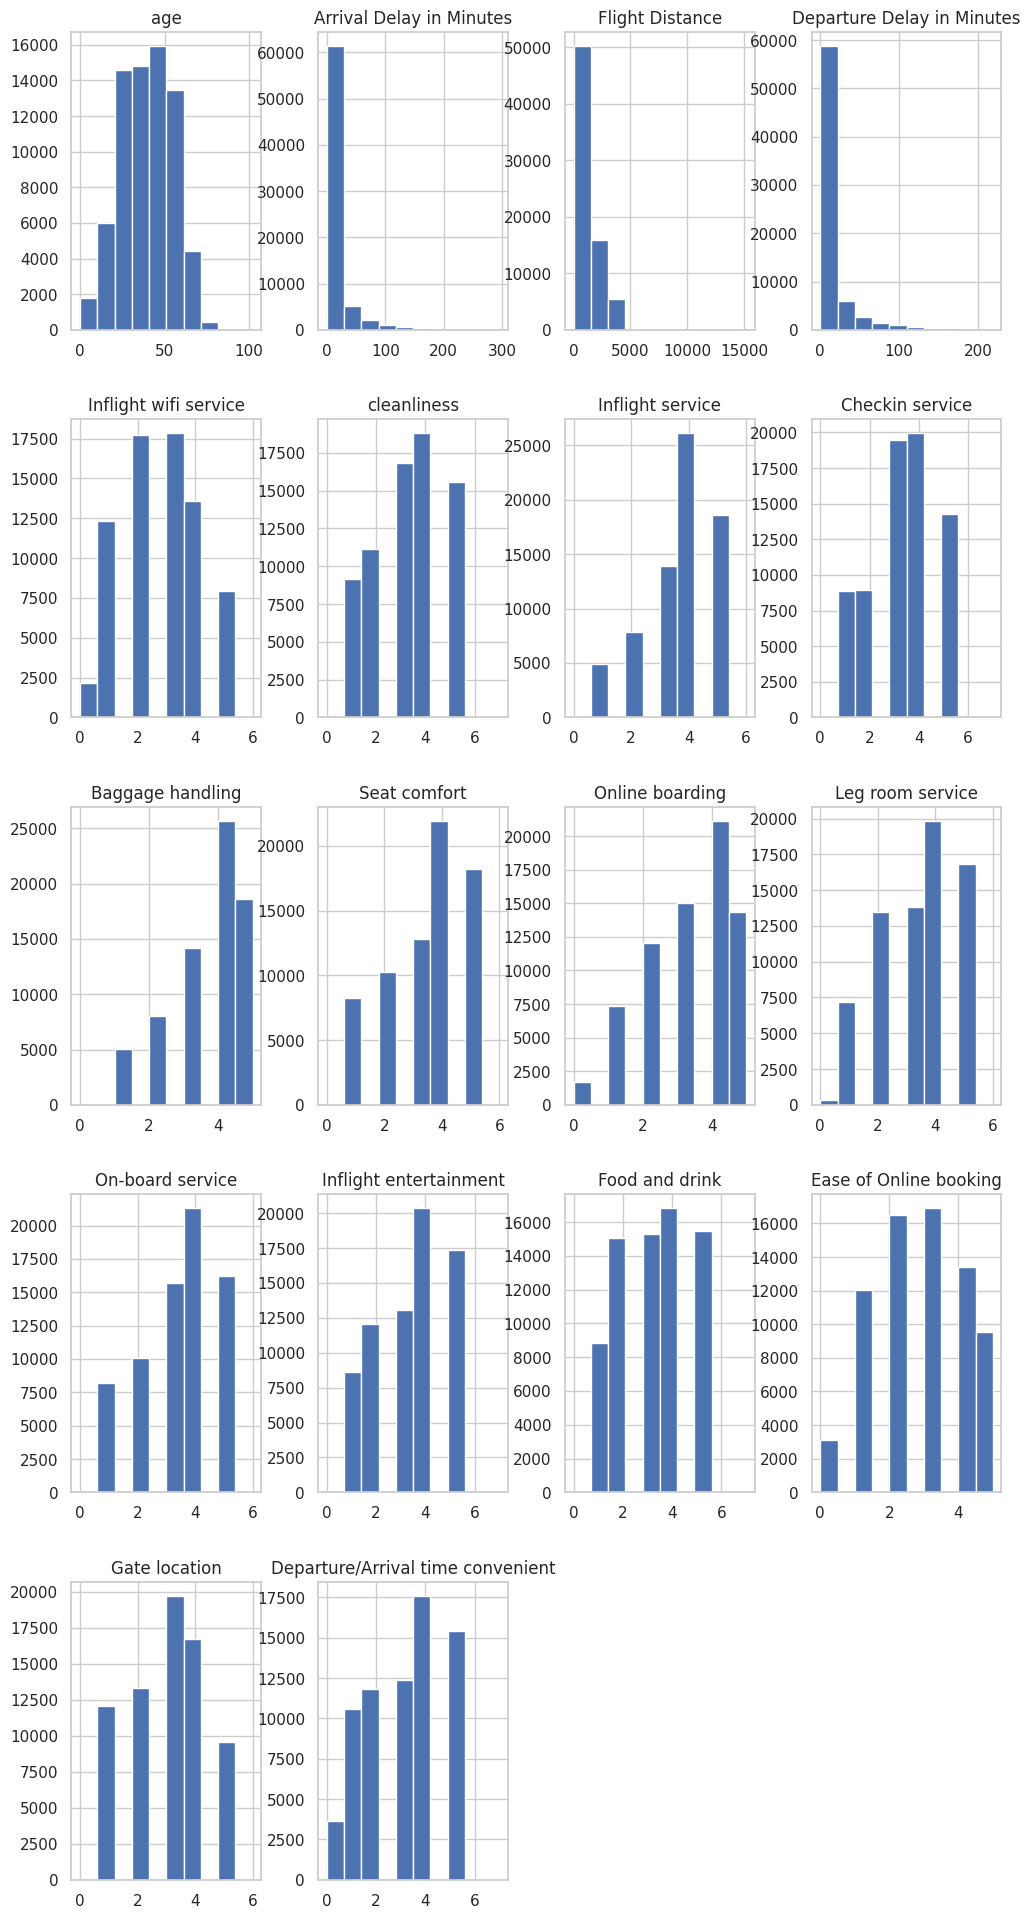

In [417]:
X_train.hist(figsize=(12, 24));

Распределение выглядят нормально. Нет выраженных выбросов. Отсутствуют яркие провалы. Признаки распределены нормально и по пуасону


### **Задание 11. (2 балла)**

Осуществите предобработку датасета для обучения **полностью самостоятельно**, на основе вашего опыта из прошлых дз и изученной теории. Обязательно **комментируйте** каждое действие.

**Примечание:**

В данном задании ваша задача в том числе убедить ревьюера в достаточности предобработки.

Уже выполнены следующие шаги по предобработке:
- Заполнены пропуски на основании mode  
- Обработаны выбросы, на основании mean +- 3std 

In [418]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [419]:
# обработка категориальных признаков, буду использовать кодирование на месте через LabelEncoder. 
# pd.get_dummies, работает не плохо, но из моей практики кодирование на месте на уникальность 
# дает результаты не хуже, и препятствует переобучению, а также увеличивает глубину деревьев

label_encoders = {}
categorical_columns = ['gender', 'class', 'Type of Travel', 'Customer Type']
for col in categorical_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    label_encoders[col] = le

le_target = LabelEncoder()
y_train = le_target.fit_transform(y_train)

In [420]:
# Маштабирование числовых признаков. Буду использовать StandardScaler. 
# Данный этам "выравнивает" числовые признаки между собой, не дает распалзаться распределениям.
# Также на этом этапе будет добавлен feature engineering для числовых призхнаков, на овновании 
# базовых математических преобразований

scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])

In [421]:
# выполняем преобразование с X_val
categorical_columns = ['gender', 'class', 'Type of Travel', 'Customer Type']
for col in categorical_columns:
    le = label_encoders[col]
    X_val[col] = le.transform(X_val[col])

y_val = le_target.transform(y_val)
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])

In [422]:
def np_cube(array):
    return array ** 3

def np_outer(x):
    return np.outer(x, x).reshape(-1)

def np_outer_inv(x):
    return np.outer(x, np.reciprocal(x)).reshape(-1)

def np_matrix_outer(matrix):
    return np.apply_along_axis(np_outer, 1, matrix)

def np_matrix_outer_inv(matrix):
    return np.apply_along_axis(np_outer_inv, 1, matrix)

math_func = [
    (np.log, 'log'), 
    (np_cube, 'cube'), 
    (np.reciprocal, '1/x'), 
    (np.sqrt, 'sqrt'), 
    #np_matrix_outer, 
    #np_matrix_outer_inv
    ]

def num_Feature_Engineering(values: np.array, col_names=None) -> np.array:
    values += 1e-8
    features_gen = [(func(values), func_name) for func, func_name in math_func]
    total_features = [values] + [i[0] for i in features_gen]
    if col_names:
        total_cols = col_names + [f'{col_name}_{func_name}' for func_name in [i[1] for i in features_gen] for col_name in col_names]
    return np.concatenate(total_features, axis=1), total_cols if col_names is not None else None

In [426]:
X_train_fe = base_X_train.copy()
y_train_fe = base_y_train.copy()
X_val_fe = base_X_val.copy()
y_val_fe = base_y_val.copy()

X_train_fe[numerical_cols] = X_train_fe[numerical_cols].astype(float)
X_val_fe[numerical_cols] = X_val_fe[numerical_cols].astype(float)

mode_map = {k: v[0] for k, v in X_train_fe[numerical_cols].mode().to_dict(orient='list').items()}

X_train_fe = X_train_fe.fillna(mode_map)
X_val_fe = X_val_fe.fillna(mode_map)


for col in numerical_cols:
    mean = X_train_fe[col].mean()
    std = X_train_fe[col].std()
    left_th, right_th = mean - 3 * std, mean + 3 * std
    select_idx = X_train_fe[col].apply(lambda x: x > left_th and x < mean + 3 * std)
    X_train_fe = X_train_fe[select_idx]
    y_train_fe = y_train_fe[select_idx]


categorical_columns = ['gender', 'class', 'Type of Travel', 'Customer Type']
for col in categorical_columns:
    le = label_encoders[col]
    X_train_fe[col] = le.transform(X_train_fe[col])

y_train_fe = le_target.transform(y_train_fe)

In [427]:
fe_set, fe_col_names = num_Feature_Engineering(X_train_fe[numerical_cols].values, numerical_cols)

In [428]:
X_train_with_fe = pd.DataFrame(np.concatenate([fe_set, X_train_fe[categorical_columns].values], axis=1), columns=fe_col_names + categorical_columns)
total_col_names_with_fe = fe_col_names + categorical_columns

scaler_fe = StandardScaler()
X_train_with_fe[fe_col_names] = scaler_fe.fit_transform(X_train_with_fe[fe_col_names])

In [429]:
categorical_columns = ['gender', 'class', 'Type of Travel', 'Customer Type']
for col in categorical_columns:
    le = label_encoders[col]
    X_val_fe[col] = le.fit_transform(X_val_fe[col])

y_val_fe = le_target.transform(y_val_fe)

fe_set_val, _ = num_Feature_Engineering(X_val_fe[numerical_cols].values, numerical_cols)
X_val_with_fe = pd.DataFrame(np.concatenate([fe_set_val, X_val_fe[categorical_columns].values], axis=1), columns=fe_col_names + categorical_columns)
X_val_with_fe[fe_col_names] = scaler_fe.transform(X_val_with_fe[fe_col_names])

In [433]:
# X_train, y_train
# X_train_with_fe, y_train
# X_val, y_val
# X_val_with_fe, y_val

### **Задание 12. (0.25 балла)**

- Обучите самописное дерево и Random Forest с базовыми гиперпараметрами. Выведите `f1-score`.

In [434]:
from hw4_code_pro import DecisionTree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [435]:
_X_train = X_train[numerical_cols + categorical_columns]
feature_types = ['real']*len(numerical_cols) +  ['categorical'] * len(categorical_columns)
custom_tree = DecisionTree(feature_types)
custom_tree.fit(_X_train.values, y_train)


y_pred = custom_tree.predict(X_val.values)
print(f'val_f1_score: {f1_score(y_val, y_pred): .5f}')

val_f1_score:  0.58173


In [436]:
feature_types = ['real']*fe_set.shape[-1] +  ['categorical'] * len(categorical_columns)
custom_tree = DecisionTree(feature_types)
custom_tree.fit(X_train_with_fe.values, y_train_fe)


y_pred = custom_tree.predict(X_val_with_fe.values)
print(f'val_f1_score: {f1_score(y_val_fe, y_pred): .5f}')

val_f1_score:  0.79926


In [437]:
_X_train = X_train[numerical_cols + categorical_columns]
rf = RandomForestClassifier()
rf.fit(_X_train.values, y_train)


y_pred = rf.predict(X_val.values)
print(f'val_f1_score: {f1_score(y_val, y_pred): .5f}')

val_f1_score:  0.46697


In [438]:
rf = RandomForestClassifier()
rf.fit(X_train_with_fe.values, y_train_fe)


y_pred = rf.predict(X_val_with_fe.values)
print(f'val_f1_score: {f1_score(y_val_fe, y_pred): .5f}')

val_f1_score:  0.95267


### **Задание 13. (0.4 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса и дерева (если реализовали их в бонусе), используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).
- Сравните качество полученных моделей и выберите лучшую. Лучшую модель сохраните в pickle.

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [439]:
from sklearn.model_selection import RandomizedSearchCV
from hw4_code_pro import DecisionTree
from scipy.stats import uniform

param_dist_rf = {
    'n_estimators': list(range(100, 151, 10)),
    'max_depth': [None] + list(range(5, 15)),
    'min_samples_split': list(range(2, 20, 2)),
    'min_samples_leaf': list(range(1, 11, 2)),
    'max_features': ['sqrt', 'log2']
}

param_dist_custo_dt = {
    'max_depth': [None] + list(range(5, 15)),
    'min_samples_split': list(range(2, 20, 2)),
    'min_samples_leaf': list(range(1, 11, 2)),
}

In [440]:
_X_train = X_train[numerical_cols + categorical_columns]
rf = RandomForestClassifier(random_state=42)
rf_search = RandomizedSearchCV(rf, param_distributions=param_dist_rf, n_iter=50, cv=5, scoring='f1', random_state=42, n_jobs=-1)
rf_search.fit(_X_train.values, y_train)
best_rf = rf_search.best_estimator_

y_pred = best_rf.predict(X_val.values)
print(f'val_f1_score: {f1_score(y_val, y_pred): .5f}')

val_f1_score:  0.46971


In [441]:
rf = RandomForestClassifier(random_state=42)
rf_search_fe = RandomizedSearchCV(rf, param_distributions=param_dist_rf, n_iter=50, cv=5, scoring='f1', random_state=42, n_jobs=-1)
rf_search_fe.fit(X_train_with_fe.values, y_train_fe)
best_rf_fe = rf_search_fe.best_estimator_

y_pred = best_rf_fe.predict(X_val_with_fe.values)
print(f'val_f1_score: {f1_score(y_val_fe, y_pred): .5f}')

val_f1_score:  0.95004


In [442]:
_X_train = X_train[numerical_cols + categorical_columns]
feature_types = ['real']*len(numerical_cols) +  ['categorical'] * len(categorical_columns)
custom_tree = DecisionTree(feature_types)
custom_dt_search = RandomizedSearchCV(custom_tree, param_distributions=param_dist_custo_dt, n_iter=50, cv=5, scoring='f1', random_state=42, n_jobs=-1)
custom_dt_search.fit(_X_train.values, y_train)
best_custom_dt = custom_dt_search.best_estimator_

y_pred = best_custom_dt.predict(X_val.values)
print(f'val_f1_score: {f1_score(y_val, y_pred): .5f}')

val_f1_score:  0.58173


In [443]:
feature_types = ['real']*fe_set.shape[-1] +  ['categorical'] * len(categorical_columns)
custom_tree = DecisionTree(feature_types)
custom_dt_search_fe = RandomizedSearchCV(custom_tree, param_distributions=param_dist_custo_dt, n_iter=50, cv=5, scoring='f1', random_state=42, n_jobs=-1)
custom_dt_search_fe.fit(X_train_with_fe.values, y_train_fe)
best_custom_dt_fe = custom_dt_search_fe.best_estimator_

y_pred = best_custom_dt_fe.predict(X_val_with_fe.values)
print(f'val_f1_score: {f1_score(y_val_fe, y_pred): .5f}')

val_f1_score:  0.79981


### **Задание 14. Анализ моделей (0.1 балла)**

- Отобразите`feature_importances_` вашего лучшего случайного леса;
- Проанализируйте, какие признаки оказались важными?

In [276]:
sorted(zip(best_rf.feature_importances_, numerical_cols + categorical_columns), key=lambda x: x[0], reverse=True)[:5]

[(0.19074113626930603, 'Online boarding'),
 (0.15106142510243828, 'Inflight wifi service'),
 (0.10873868273285028, 'class'),
 (0.10420155332128458, 'Type of Travel'),
 (0.060962130863198065, 'Inflight entertainment')]

Online boarding  
Inflight wifi service  
class  
Type of Travel  
Inflight entertainment

In [277]:
sorted(zip(best_rf_fe.feature_importances_, total_col_names_with_fe), key=lambda x: x[0], reverse=True)[:5]

[(0.07419961162202124, 'Online boarding_log'),
 (0.07065639759766794, 'Online boarding_sqrt'),
 (0.06852593020817724, 'Type of Travel'),
 (0.057458783636288514, 'Online boarding'),
 (0.0573833330888428, 'class')]

In [454]:

import pickle
filename = 'best_model.sav'
pickle.dump(best_rf_fe, open(filename, 'wb'))

### **Задание 15. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

PermutationExplainer explainer: 5001it [25:53,  3.20it/s]                          


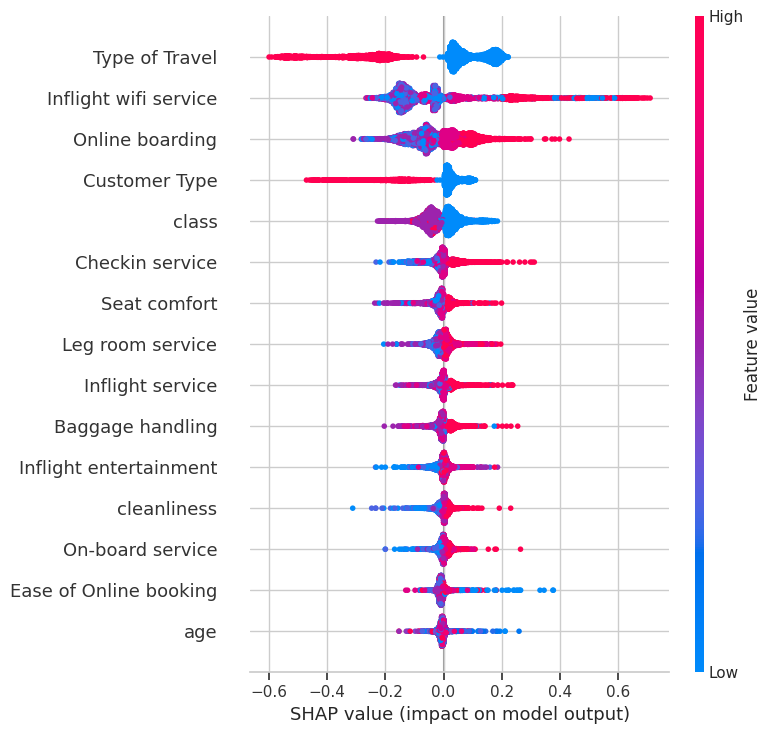

In [444]:
import shap
sub_set_df = X_val[numerical_cols + categorical_columns].sample(5000, random_state=42)
explainer = shap.Explainer(best_rf.predict, sub_set_df)
shap_values = explainer(sub_set_df)
shap.summary_plot(shap_values, sub_set_df, max_display=15)

PermutationExplainer explainer: 5001it [17:16,  4.78it/s]                          


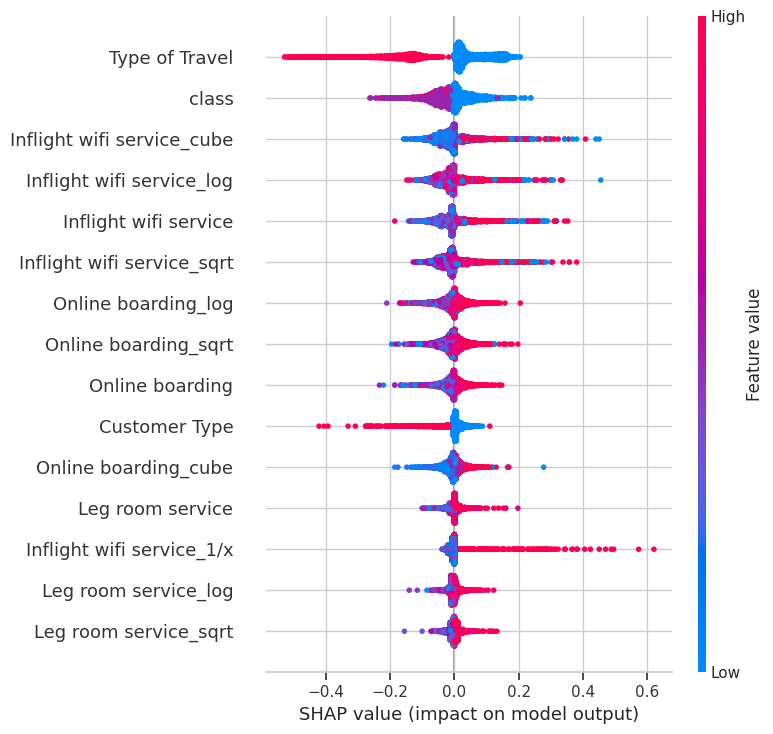

In [445]:
sub_set_df_fe = X_val_with_fe.sample(5000, random_state=42)
explainer_2 = shap.Explainer(best_rf_fe.predict, sub_set_df_fe)
shap_values_2 = explainer_2(sub_set_df_fe)
shap.summary_plot(shap_values_2, sub_set_df_fe, max_display=15)

Как и во feature_importances_ лидеры по важности не изменились, однако из порядок изменился.  
На графиках видна степень разделения выборок, "Type of Travel" имеет наиболее корректное разбиение. Т.к. можно наблюдать два полностью разделенных кластера.  

Для выборки без FE следующий порядок важности признаков
- Type of Travel 
- Inflight wifi service  
- Online boarding  
- Customer Type  
- class  
  
Против:  
- Online boarding  
- Inflight wifi service  
- class  
- Type of Travel  
- Inflight entertainment  
  
  
Для выборки с FE следующий порядок важности признаков
- Type of Travel 
- class  
- Inflight wifi service    
- Inflight wifi service_log   
- Online boarding_sqrt  
  
Против:  
- Online boarding_sqrt  
- Online boarding_log    
- Online boarding_1/x    
- Type of Travel  
- Online boarding_cube  

### **Задание 16. (0.25 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [446]:
import lime
import lime.lime_tabular

In [447]:
feature_names = numerical_cols + categorical_columns
cat_indices = [feature_names.index(col) for col in categorical_columns]

In [448]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, 
    discretize_continuous=True,
    class_names=['neutral or dissatisfied', 'satisfied'], 
    mode="classification",
    feature_names = feature_names,
    categorical_features=cat_indices,
    categorical_names=categorical_columns, 
    kernel_width=10, 
    verbose=True
    )

In [449]:
idx = 42
exp = explainer.explain_instance(
    X_val.iloc[idx].values,
    best_rf.predict_proba,
    num_features=10
)
exp.show_in_notebook()

Intercept 0.5310858248833747
Prediction_local [0.49546241]
Right: 0.6522883455029974


In [450]:
feature_names = total_col_names_with_fe#numerical_cols + categorical_columns
cat_indices = [feature_names.index(col) for col in categorical_columns]

In [451]:
explainer_2 = lime.lime_tabular.LimeTabularExplainer(
    X_val_with_fe.values, 
    discretize_continuous=True,
    class_names=['neutral or dissatisfied', 'satisfied'], 
    mode="classification",
    feature_names = feature_names,
    categorical_features=cat_indices,
    categorical_names=categorical_columns, 
    kernel_width=10, 
    verbose=True
    )

In [453]:
idx = 42
exp = explainer_2.explain_instance(
    X_val_with_fe.iloc[idx].values,
    best_rf_fe.predict_proba,
    num_features=10
)
exp.show_in_notebook()

Intercept 0.2506508412225443
Prediction_local [0.45645158]
Right: 0.8466116650622949


С помощью LIME можно наблюдать величину вклада ряда признаков в конечный таргет,  
так для FE setup (42 idx sample) видно что наибольший вклад внес type of travel.

## Котобонус!

0.25 балла

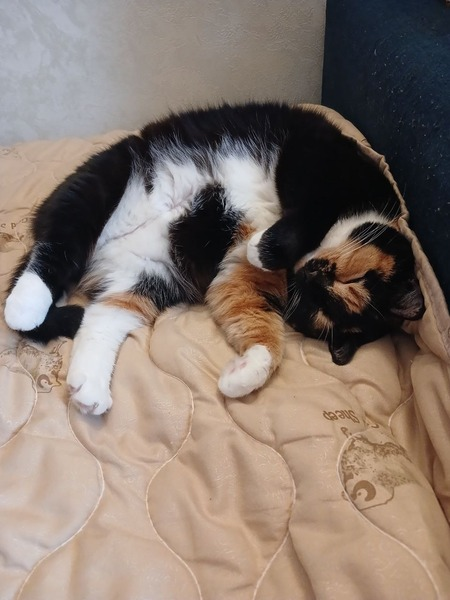

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?